# II. Model Comparison

## Objective

Train and compare two supervised tree-based ensemble classifiers on the fault-detection task:

| Model | Role |
|---|---|
| Random Forest | Bagged ensemble of decision trees |
| XGBoost | Sequential gradient-boosted trees |

Tree-based ensemble methods are selected because each landing event is treated as an **independent observation** represented by a fixed-length scalar feature vector. These models do not assume temporal continuity across observations, align naturally with event-level tabular data, and provide interpretable feature-importance outputs.

## Target Variable

`Fault_Code` — four mutually exclusive ground-truth classes injected into the simulation:

| Code | Failure Mode | Physical Effect |
|---|---|---|
| 0 | Normal Operation | Nominal stiffness and damping |
| 1 | Nitrogen Gas Leak | Reduced gas-spring stiffness (K ↓) |
| 2 | Worn Seal | Reduced hydraulic damping (B ↓) |
| 3 | Early Structural Degradation | Combined stiffness and damping loss |

Physics-derived features (ζ and ω_n) are included alongside raw signals — they are directly sensitive to the K and B changes that define faults 1 through 3.

## Setup

Import all required libraries. RANDOM_STATE=42 ensures every stochastic step (train/test split, model initialisation) is fully reproducible.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from xgboost import XGBClassifier

sns.set_theme(style="whitegrid", context="notebook")  # consistent styling for all plots
RANDOM_STATE = 42

## Data Loading and Feature Engineering

### Dataset origin

The CSV contains **1 500 simulated landing events**. Each row is one landing event; fault conditions were injected at the simulation level, so `Fault_Code` reflects the ground-truth state of the digital twin.

### Column reference

| Column | Unit | Type | Description |
|---|---|---|---|
| `RunID` | — | Identifier | Unique simulation run index; excluded from modelling |
| `Max_Deflection` | m | Sensor signal | Peak shock-strut compression during impact |
| `Max_Velocity` | m/s | Sensor signal | Maximum vertical piston velocity during impact |
| `Settling_Time` | s | Sensor signal | Time for oscillations to decay to within 2 % of steady state — directly sensitive to damping faults |
| `Mass` | kg | Simulation input | Dornier 228 landing mass, swept 3 000 – 6 400 kg across runs |
| `K_Stiffness` | N/m | Latent physics param | Gas-spring stiffness of the strut; exposed by the digital twin, not a physical sensor |
| `B_Damping` | N·s/m | Latent physics param | Hydraulic damping coefficient; latent parameter from the Simscape model |
| `Fault_Code` | — | Target (class) | Ground-truth failure mode injected into the simulation |
| `RUL` | % | Target (regression) | Remaining Useful Life; reserved for a regression task, not used here |

### Physics-derived features

Two features are computed from the latent Simscape parameters to make the physical fault signatures explicit:

- **ζ (damping ratio)** = B / (2√(K · m)) — dimensionless. A **Worn Seal** reduces B → ζ drops. A **N₂ Gas Leak** reduces K → both ζ and ω_n shift simultaneously.
- **ω_n (natural frequency)** = √(K / m) — rad/s. Falls when K decreases (faults 1 and 3).

In a real operational context, the stiffness (K) and damping (B) coefficients of a landing gear strut are not directly accessible through sensors. Instead, the damping ratio (ζ) and natural frequency (ω_n) — which encode the same physical information — can be estimated from measurable dynamic responses such as strut deflection and oscillation decay. This makes them the natural bridge between knowledge generated by the digital twin and system health inference on an actual aircraft.

In [2]:
DATA_PATH = Path("../data/raw/LandingGear_Balanced_Dataset.csv")
df = pd.read_csv(DATA_PATH)

# Physics-informed feature engineering
df["zeta"]   = df["B_Damping"] / (2 * np.sqrt(df["K_Stiffness"] * df["Mass"])) # damping ratio
df["omega_n"] = np.sqrt(df["K_Stiffness"] / df["Mass"]) # natural frequency

print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")
print("Fault_Code distribution:")
print(df["Fault_Code"].value_counts().sort_index())

Dataset: 1,500 rows, 11 columns
Fault_Code distribution:
Fault_Code
0    300
1    500
2    500
3    200
Name: count, dtype: int64


## Feature Selection and Train-Test Split

The feature matrix **X** contains three observable sensor signals (`Max_Deflection`, `Max_Velocity`, `Settling_Time`), one simulation input (`Mass`), two latent physics parameters exposed by the digital twin (`K_Stiffness`, `B_Damping`), and the two derived physics features (`zeta`, `omega_n`). `RunID` and `RUL` are excluded.

The dataset is split **80 / 20** with **stratification** on `Fault_Code` to preserve the class distribution in both partitions. Random Forest and XGBoost are scale-invariant tree-based models — no feature normalisation is required.

In [3]:
CLASS_NAMES = {
    0: "Normal Operation",
    1: "N2 Gas Leak",
    2: "Worn Seal",
    3: "Early Structural Degradation",
}

FEATURE_COLS = [
    "Max_Deflection", "Max_Velocity", "Settling_Time",
    "Mass", "K_Stiffness", "B_Damping",
    "zeta", "omega_n",
]
TARGET = "Fault_Code"

X = df[FEATURE_COLS].values
y = df[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print(f"Train : {len(X_train):,} samples")
print(f"Test  : {len(X_test):,} samples")

Train : 1,200 samples
Test  : 300 samples


## Helper Function

`evaluate_model` prints a full per-class classification report and returns a summary dict with accuracy and **macro-averaged** precision, recall, and F1. Macro averaging computes each metric independently per class then takes the unweighted mean — giving equal weight to every fault type regardless of class size, consistent with the paper's evaluation design.

In [4]:
def evaluate_model(name, y_true, y_pred):
    """Return headline metrics and print a full classification report."""
    labels = sorted(set(y_true))
    print("=" * 55)
    print(f"  {name}")
    print("=" * 55)
    print(classification_report(
        y_true, y_pred,
        target_names=[CLASS_NAMES[i] for i in labels],
    ))
    return {
        "Model"    : name,
        "Accuracy" : round(accuracy_score(y_true, y_pred), 4),
        "Precision": round(precision_score(y_true, y_pred, average="macro"), 4),
        "Recall"   : round(recall_score(y_true, y_pred, average="macro"), 4),
        "F1"       : round(f1_score(y_true, y_pred, average="macro"), 4),
    }

results = []

## Random Forest

A Random Forest of 300 decision trees, each trained on a bootstrap sample with a random feature subset (max_features=sqrt) at every split. Ensemble averaging reduces variance compared to a single tree. The **unscaled** feature matrix is used since tree-based models are invariant to monotonic feature transformations.

In [5]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_features="sqrt", # sqrt of total features for better generalization
    n_jobs=-1, # use all CPU cores for faster training
    random_state=RANDOM_STATE,
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

results.append(evaluate_model("Random Forest", y_test, y_pred_rf))

  Random Forest
                              precision    recall  f1-score   support

            Normal Operation       1.00      0.97      0.98        60
                 N2 Gas Leak       1.00      1.00      1.00       100
                   Worn Seal       0.98      1.00      0.99       100
Early Structural Degradation       1.00      1.00      1.00        40

                    accuracy                           0.99       300
                   macro avg       1.00      0.99      0.99       300
                weighted avg       0.99      0.99      0.99       300



## XGBoost

XGBoost builds trees **sequentially**, each correcting the residual errors of the ensemble so far.

| Parameter | Value | Reason |
|---|---|---|
| n_estimators | 300 | Number of boosting rounds |
| learning_rate | 0.1 | Shrinks each tree contribution to reduce overfitting |
| max_depth | 6 | Per-tree complexity limit |
| subsample | 0.8 | Row subsampling - stochastic regularisation |
| colsample_bytree | 0.8 | Column subsampling per tree |

In [6]:
# XGBoost with tuned hyperparameters for better performance on this dataset
# These parameters were chosen based on common defaults and best practices for multi-class classification
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

results.append(evaluate_model("XGBoost", y_test, y_pred_xgb))

C:\Users\Zsolti\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:200: UserWarning: [17:37:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  XGBoost
                              precision    recall  f1-score   support

            Normal Operation       1.00      0.95      0.97        60
                 N2 Gas Leak       0.99      1.00      1.00       100
                   Worn Seal       0.98      1.00      0.99       100
Early Structural Degradation       1.00      1.00      1.00        40

                    accuracy                           0.99       300
                   macro avg       0.99      0.99      0.99       300
                weighted avg       0.99      0.99      0.99       300



## Metric Summary

Collect all per-model metrics into a single DataFrame for a side-by-side comparison, then render as a grouped bar chart so relative differences are immediately visible.

,Accuracy,Precision,Recall,F1
Model,,,,
Random Forest,0.9933,0.9951,0.9917,0.9933
XGBoost,0.9900,0.9926,0.9875,0.9899


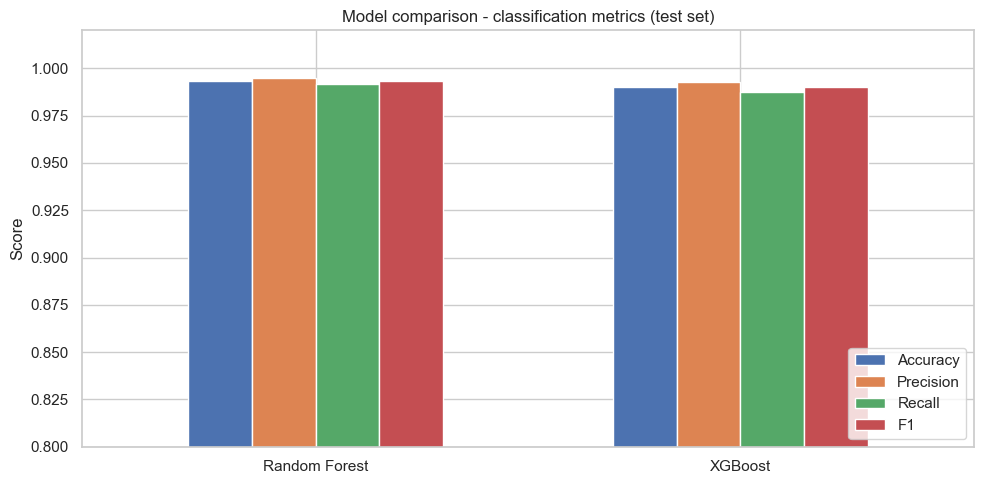

In [7]:
summary = pd.DataFrame(results).set_index("Model")
display(summary)

ax = summary.plot(kind="bar", figsize=(10, 5), ylim=(0.8, 1.02), width=0.6)
ax.set_title("Model comparison - classification metrics (test set)")
ax.set_ylabel("Score")
ax.set_xlabel("")
ax.tick_params(axis="x", rotation=0)
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Cross-Validation Stability Check

A single train/test split can be sensitive to which samples land in which partition. **Stratified 5-fold cross-validation** repeats evaluation across five non-overlapping folds, providing a mean and standard deviation for each model's **macro-averaged F1** score. A low standard deviation confirms the test-set result is representative and not an artefact of the particular split.

Random Forest             macro F1 = 0.9902 +/- 0.0049
XGBoost                   macro F1 = 0.9981 +/- 0.0024


C:\Users\Zsolti\AppData\Local\Temp\ipykernel_5636\1487191578.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(cv_results.values(), labels=cv_results.keys(), patch_artist=True)


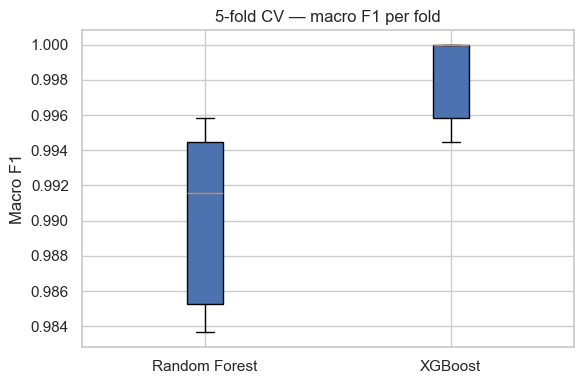

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = {}
for name, model in [
    ("Random Forest", rf),
    ("XGBoost",       xgb),
]:
    scores = cross_validate(
        model, X_train, y_train,
        cv=cv, scoring="f1_macro", n_jobs=-1,
    )["test_score"]
    cv_results[name] = scores
    # Print mean and std of macro F1 across folds for each model
    print(f"{name:<25} macro F1 = {scores.mean():.4f} +/- {scores.std():.4f}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.boxplot(cv_results.values(), labels=cv_results.keys(), patch_artist=True)
ax.set_title("5-fold CV — macro F1 per fold")
ax.set_ylabel("Macro F1")
ax.tick_params(axis="x", rotation=0)
plt.tight_layout()
plt.show()

## Confusion Matrices

A confusion matrix shows the count of true vs. predicted labels for every class combination. Diagonal cells are correct predictions; off-diagonal cells are misclassifications. Comparing matrices across models reveals which fault classes each model struggles with, not just the aggregate error rate.

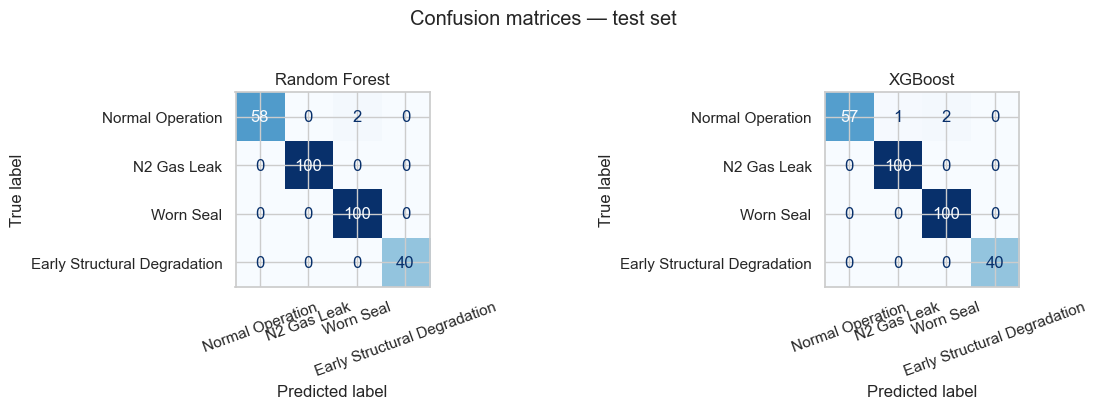

In [9]:
class_labels = [CLASS_NAMES[i] for i in sorted(set(y_test))]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (name, y_pred) in zip(axes, [
    ("Random Forest", y_pred_rf),
    ("XGBoost",       y_pred_xgb),
]):
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=class_labels,
        cmap="Blues",
        ax=ax,
        colorbar=False,
    )
    ax.set_title(name)
    ax.tick_params(axis="x", rotation=20)

plt.suptitle("Confusion matrices — test set", y=1.02)
plt.tight_layout()
plt.show()

## Feature Importance

Tree-based models expose a built-in feature-importance score - the mean decrease in impurity (Gini) across all splits that used each feature. Comparing rankings between Random Forest and XGBoost highlights the contribution of the physics-derived features (zeta, omega_n) relative to the raw sensor measurements.

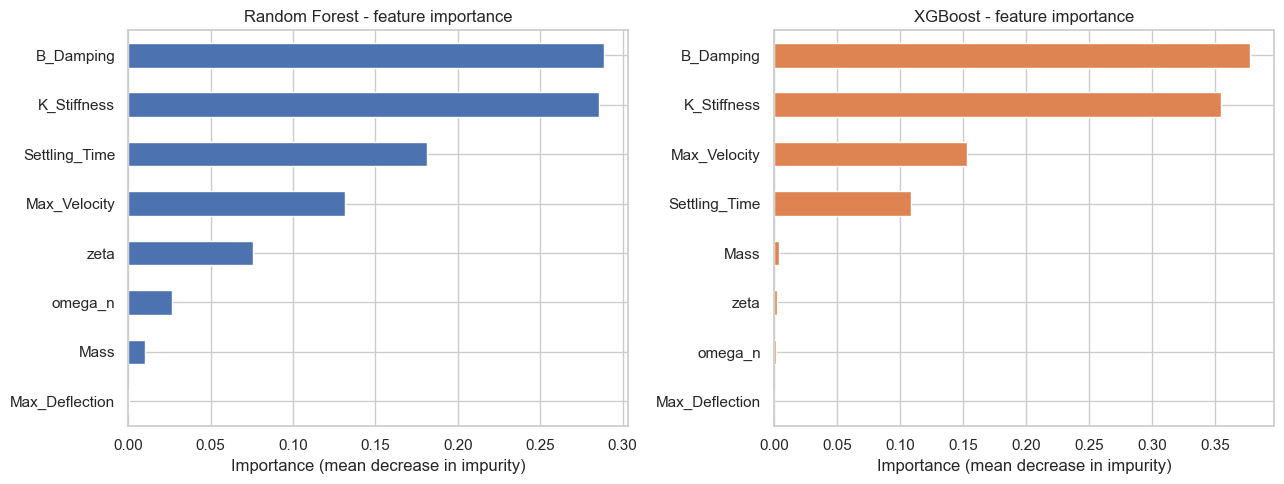

In [10]:
fi_rf  = pd.Series(rf.feature_importances_,  index=FEATURE_COLS).sort_values()
fi_xgb = pd.Series(xgb.feature_importances_, index=FEATURE_COLS).sort_values()

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fi_rf.plot( kind="barh", ax=axes[0], color="#4c72b0",
           title="Random Forest - feature importance")
fi_xgb.plot(kind="barh", ax=axes[1], color="#dd8452",
           title="XGBoost - feature importance")
for ax in axes:
    ax.set_xlabel("Importance (mean decrease in impurity)")
plt.tight_layout()
plt.show()

## Cross-Dataset Generalizability — AEROTWIN Do228 V16.1

To assess whether the trained classifiers generalise beyond the primary dataset, a **cross-dataset evaluation** is performed using the **AEROTWIN Do228 V16.1** dataset (Bello Sani, 2026) as a fully independent external test set. AEROTWIN contains 9,500 simulated landing events across 11 fault classes generated by the same Dornier 228 digital twin framework.

### Feature alignment

Two primary dataset features are unavailable in AEROTWIN:

| Feature | Status in AEROTWIN |
|---|---|
| `Settling_Time` | Absent — no equivalent column |
| `Max_Deflection` | Zero variance — single value across all 9,500 records |

The cross-dataset classifier therefore uses a **reduced 6-feature set**: `Max_Velocity`, `Mass`, `K_Stiffness`, `B_Damping`, `zeta`, `omega_n`. Both `zeta` and `omega_n` are computable (similarly as shown above) from the structural parameters available in AEROTWIN.

### Evaluation scope

Only the 4 fault classes shared with the primary dataset (codes 0–3) are evaluated. AEROTWIN serves as the external test set in its entirety — no further splitting is performed. A separate pair of classifiers is retrained on the primary training set using only the 6 shared features before being applied to AEROTWIN.

| Code | Fault Mode | AEROTWIN Count |
|---|---|---|
| 0 | Normal Operation | 1,500 |
| 1 | N2 Gas Leak | 1,500 |
| 2 | Worn Seal | 1,500 |
| 3 | Early Structural Degradation | 1,000 |

Due to this class imbalance, **per-class F1-scores** are reported alongside the confusion matrix.

In [11]:
AEROTWIN_PATH = Path("../data/raw/AEROTWIN_Dataset_Preprocessed_ZSK.csv")
df_aero = pd.read_csv(AEROTWIN_PATH)

# Rename target column to align with primary dataset convention
df_aero = df_aero.rename(columns={"Class": "Fault_Code"})

# Filter to the 4 shared fault classes only
SHARED_CLASSES = [0, 1, 2, 3]
df_aero = df_aero[df_aero["Fault_Code"].isin(SHARED_CLASSES)].copy()

# Compute physics-derived features from the structural parameters
df_aero["zeta"]    = df_aero["B_Damping"] / (2 * np.sqrt(df_aero["K_Stiffness"] * df_aero["Mass"]))
df_aero["omega_n"] = np.sqrt(df_aero["K_Stiffness"] / df_aero["Mass"])

print(f"AEROTWIN (shared classes only): {df_aero.shape[0]:,} rows")
print("Class distribution:")
print(df_aero["Fault_Code"].value_counts().sort_index())

AEROTWIN (shared classes only): 5,500 rows
Class distribution:
Fault_Code
0    1500
1    1500
2    1500
3    1000
Name: count, dtype: int64


In [12]:
# Reduced 6-feature set — features available in both datasets
FEATURE_COLS_6 = ["Max_Velocity", "Mass", "K_Stiffness", "B_Damping", "zeta", "omega_n"]

# Extract the corresponding column indices from the original 8-feature training array
idx6 = [FEATURE_COLS.index(f) for f in FEATURE_COLS_6]
X_train_6 = X_train[:, idx6]

# Retrain classifiers on the primary training set using only the 6 shared features
rf6 = RandomForestClassifier(
    n_estimators=300, max_features="sqrt", n_jobs=-1, random_state=RANDOM_STATE
)
rf6.fit(X_train_6, y_train)

xgb6 = XGBClassifier(
    n_estimators=300, learning_rate=0.1, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    eval_metric="mlogloss", use_label_encoder=False,
    random_state=RANDOM_STATE, n_jobs=-1,
)
xgb6.fit(X_train_6, y_train)

print("6-feature classifiers retrained on primary training set.")

C:\Users\Zsolti\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:200: UserWarning: [17:37:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


6-feature classifiers retrained on primary training set.


  Random Forest — AEROTWIN (6-feat)
                              precision    recall  f1-score   support

            Normal Operation       0.35      0.64      0.45      1500
                 N2 Gas Leak       0.00      0.00      0.00      1500
                   Worn Seal       0.43      0.79      0.56      1500
Early Structural Degradation       0.00      0.00      0.00      1000

                    accuracy                           0.39      5500
                   macro avg       0.19      0.36      0.25      5500
                weighted avg       0.21      0.39      0.28      5500

  XGBoost — AEROTWIN (6-feat)
                              precision    recall  f1-score   support

            Normal Operation       0.43      0.65      0.52      1500
                 N2 Gas Leak       0.99      0.33      0.50      1500
                   Worn Seal       0.43      0.79      0.56      1500
Early Structural Degradation       0.00      0.00      0.00      1000

                   

C:\Users\Zsolti\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Zsolti\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Zsolti\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

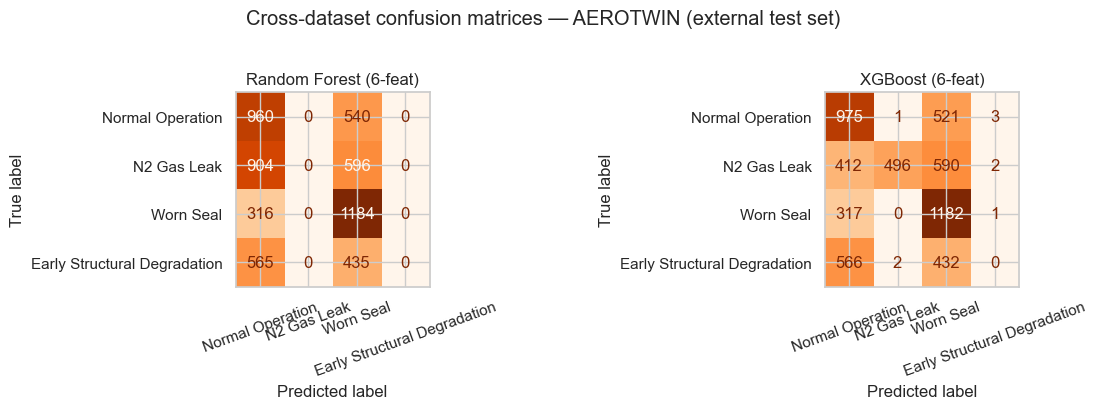

In [13]:
# Evaluate the 6-feature models on the AEROTWIN dataset (external test set)s
X_aero = df_aero[FEATURE_COLS_6].values
y_aero = df_aero["Fault_Code"].values

y_pred_rf6  = rf6.predict(X_aero)
y_pred_xgb6 = xgb6.predict(X_aero)

aero_labels = [CLASS_NAMES[i] for i in sorted(SHARED_CLASSES)]

# Per-class classification reports
for name, y_pred in [
    ("Random Forest — AEROTWIN (6-feat)", y_pred_rf6),
    ("XGBoost — AEROTWIN (6-feat)",       y_pred_xgb6),
]:
    print("=" * 55)
    print(f"  {name}")
    print("=" * 55)
    print(classification_report(y_aero, y_pred, target_names=aero_labels))

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, (name, y_pred) in zip(axes, [
    ("Random Forest (6-feat)", y_pred_rf6),
    ("XGBoost (6-feat)",       y_pred_xgb6),
]):
    ConfusionMatrixDisplay.from_predictions(
        y_aero, y_pred,
        display_labels=aero_labels,
        cmap="Oranges",
        ax=ax,
        colorbar=False,
    )
    ax.set_title(name)
    ax.tick_params(axis="x", rotation=20)

plt.suptitle("Cross-dataset confusion matrices — AEROTWIN (external test set)", y=1.02)
plt.tight_layout()
plt.show()

## Key Findings

### Within-dataset results (primary dataset, 8-feature set, 20 % hold-out test set)

| Model | Accuracy | Macro F1 | Macro Precision | Macro Recall |
|---|---|---|---|---|
| **Random Forest** | **0.9933** | **0.9933** | **0.9951** | **0.9917** |
| XGBoost | 0.9900 | 0.9899 | 0.9926 | 0.9875 |

**Random Forest is the best-performing model** on the within-dataset task — achieving 99.3 % accuracy and a macro F1 of 0.9933, marginally ahead of XGBoost (0.9899). Both models correctly classify nearly all 300 test-set events; the only misclassifications involve the Normal Operation class (the smallest class at 60 test samples).

### Cross-validation stability (5-fold stratified, macro F1 on training set)

| Model | Mean macro F1 | Std |
|---|---|---|
| Random Forest | 0.9902 | ±0.0049 |
| XGBoost | 0.9981 | ±0.0024 |

XGBoost achieves a higher and more stable CV score across folds. The small gap between XGBoost's CV mean (0.9981) and its test-set F1 (0.9899) indicates mild overfitting to the training distribution. Random Forest shows tighter alignment between its CV mean (0.9902) and test F1 (0.9933), suggesting more consistent generalisation.

### Feature importance

Both models agree on the top two features: **`B_Damping`** and **`K_Stiffness`** dominate classification, accounting for ~57 % of RF importance and ~73 % of XGBoost importance. This is physically consistent — the four fault classes are defined by injecting changes to exactly these two parameters (reduced K for N2 Gas Leak, reduced B for Worn Seal). `Settling_Time` and `Max_Velocity` provide secondary discriminative signal. `Max_Deflection` carries near-zero importance in both models (RF: 0.0005, XGBoost: 0.0000), confirming it adds no diagnostic value. The physics-derived feature `zeta` contributes meaningfully in RF (0.0756) but is redundant in XGBoost, which captures the same information directly through `B_Damping` and `K_Stiffness`.

### Cross-dataset generalisation (AEROTWIN, 6-feature set, external test set)

| Model | Accuracy | Macro F1 |
|---|---|---|
| Random Forest (6-feat) | 0.39 | 0.2522 |
| XGBoost (6-feat) | 0.48 | 0.3933 |

Both models transfer poorly to AEROTWIN. Per-class F1 scores reveal the breakdown:

| Fault Class | RF F1 | XGB F1 |
|---|---|---|
| Normal Operation | 0.45 | 0.52 |
| N2 Gas Leak | 0.00 | 0.50 |
| Worn Seal | 0.56 | 0.56 |
| Early Structural Degradation | 0.00 | 0.00 |

Random Forest partially identifies Normal Operation (F1 = 0.45) and Worn Seal (F1 = 0.56) but fails entirely on N2 Gas Leak and Early Structural Degradation (precision = recall = 0 for both). XGBoost recovers N2 Gas Leak with high precision (0.99) but very low recall (0.33, F1 = 0.50), and also cannot identify Early Structural Degradation at all. The substantial **domain shift** between datasets — AEROTWIN covers a much wider operational envelope across all four shared features — explains the degradation. Models trained on the narrow primary parameter space cannot reliably discriminate fault signatures under the broader AEROTWIN conditions. This finding underscores the need for domain adaptation or retraining when transferring models across different simulation configurations.

Both models are carried forward to `03_RUL_regression.ipynb` for RUL regression, where Random Forest Regressor and XGBoost Regressor are evaluated side by side on the same primary dataset.